In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_bloch_multivector

import math

sim = Aer.get_backend('qasm_simulator')

# Algorithme de Shor

L'algorithme de Shor est le plus célébre des algorithmes quantiques car il pourrait théoriquement mettre en danger nos systèmes cryptographiques comme le _RSA_.

Voici comment le construire pour un cas simple, disons factoriser un nombre $N = 15$.

On crée un opérateur $U$ dont en estimant la phase on obtient une la plus petite période $r$ tel que $a^r \mod N = 1$ et ensuit on peut calculer le $PGDC$ de $a^{r/2}-1$ et $N$ ce qui est simple à réaliser sur ordinateur et cela nous donne un facteur de $N$. Le nombre $a$ et choisi arbitrairement, et si avec un $a$ l'algorithme échoue, il faut essayer avec un autre.

Dans cette exemple, nous utiliserons $a=7$.

In [2]:
# Opérateur U
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [3]:
# Paramètres du circuit, N_count permet de définir le nombre de qubits de comptage de l'estimation de phase
# plus N_count est grand, plus la précision de l'estimation est grande
# a est le nombre de départ pour l'algorithme de Shor
N_COUNT = 8  # number of counting qubits
a = 7

In [4]:
# Transformation de Fourier quantique inverse, utilisée pour obtenir la phase de l'opérateur U
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Ci-dessus se trouvent tout les préparatifs du circuit pour l'algorithme qui consiste essentiellement en une estimation de phase. Pour se faire on encode dans la base de Fourier l'opérateur ($2^n$ fois l'opérateur contrôlé avec $n$ le numéro du qubit) après avoir initialisé les qubits. On applique ensuite une transformée de Fourier inverse pour revenir dans la base de mesure et la partie quantique est finie !

c:\Python310\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


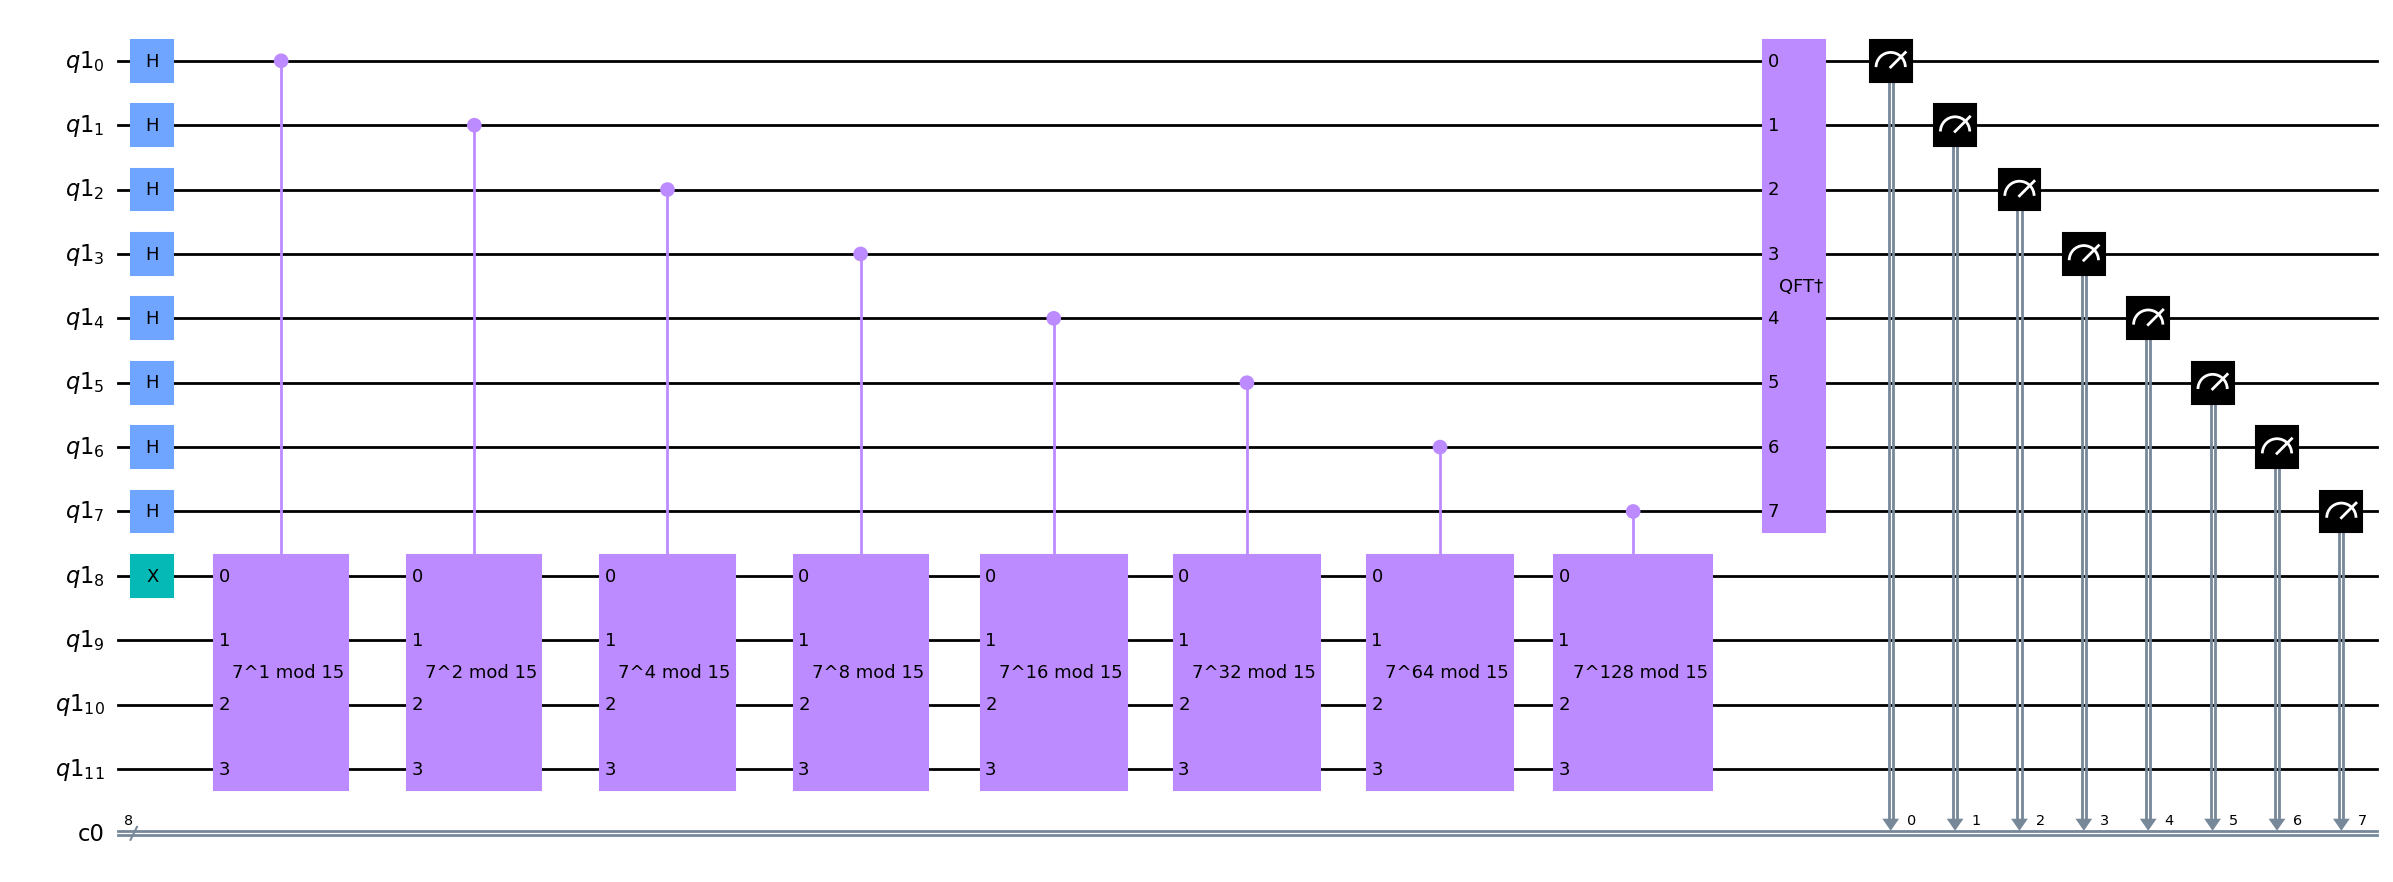

In [5]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qr = QuantumRegister(N_COUNT + 4)
cr = ClassicalRegister(N_COUNT)
qc = QuantumCircuit(qr, cr)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
              [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1, output='mpl')  # -1 means 'do not fold'

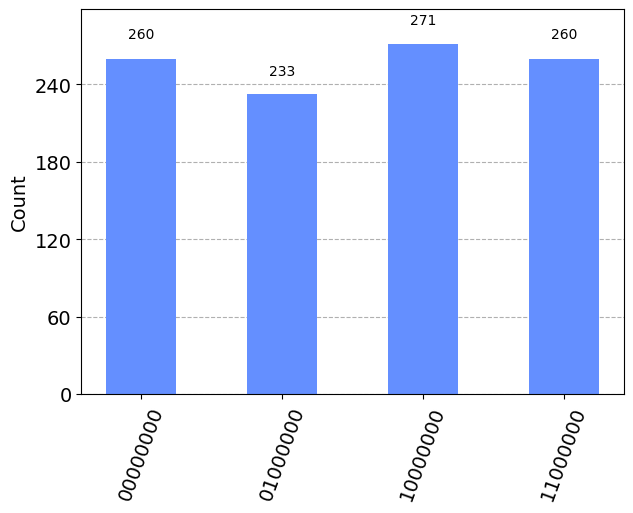

In [6]:
# mesures
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

Pour estimer la phase $\theta$ d'un opérateur $U$ sur un état $\ket{\psi}$ avec $U\ket{\psi}=e^{2\pi i \theta}\ket{\psi}$ avec $N$ qubits de comptage et comme mesure en base 10 $n$, $\theta = \frac{n}{2^N}$.

In [7]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  01000000(bin) =  64(dec)   64/256 = 0.25


Et dans ce cas on a $\theta = \frac{s}{r}$ avec $s \in \{1...r\}$ ce qui nous permet de trouver $r$ en le transformant en fraction et prenant le plus grand dénominateur.

In [8]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.25      1/4            4


Avec donc $r=4$, on obtient $a^{r/2}-1 = 7^{4/2}-1=48$ et $PGDC(48,15)=3$ qui divise bien 15. Cela parait énorme comme travail mais sur des grand nombres cela devient avantageux par rapport aux méthodes classiques. Or cette complexité donne sa puissance au cryptage RSA.

>**RSA**
>
>Le système RSA fonctionne comme suit~\cite{wiki:rsa}.
>Prenons deux personnes Alice et Bob.
>Alice crée les clés de chiffrement en choisissant deux nombres premiers $p$ et $q$ distincts.
>Alors, elle calcule le nombre $n = pq$, puis $\phi (n) = (p-1)(q-1)$, où $\phi$ est la fonction
>qui retourne la valeur de l'indicatrice d'Euler en $n$, soit le nombre de nombres premiers
>avec $n$ inférieurs à $n$.
>Cette fonction est multiplicative, c'est-à-dire que $\phi (uv) = \phi (u) \phi (v)$, et si $p$ est
>premier, alors $\phi (p) = p-1$.
>Après cela, Alice choisit un nombre $e$ premier avec $\phi (n)$, et calcule $d$ tel que
>$ed \mod \phi (n) = 1$.
>
>Alors la clé publique est le couple $(n, e)$, et la clé privée est $d$.
>Pour chiffrer un message $M$ inférieur à $n$, Bob calcule $C = M^e \mod n$, et pour déchiffrer,
>Alice calcule $M = C^d \mod n$.
>
>Cela se démontre en utilisant le petit théorème de Fermat, qui dit que si $p$ est premier,
>$M^{p-1} \mod p = 1$.
>Alors, on a $C^d \mod n = (M^e)^d \mod n = M^{ed} \mod n$.
>Or $ed \mod (p-1)(q-1) = 1$, ce qui est équivalent à $ed = 1 + k(p-1)(q-1)$ pour un certain
>$k \in \mathbb{N}$.
>De fait, d'après le petit théorème de Fermat, $M^{ed} \mod p = M^{1+k(p-1)(q-1)} \mod p = M (M^{p-1})^{k(q-1)} \mod p = M \mod p$
>et de même $M^{ed} \mod q = M \mod q$.
>De fait, $M^{ed} - M$ est congru à 0 modulo $p$ et $q$, et donc divisible par $p$ et $q$, et
>comme $p$ et $q$ sont premiers entre eux, $M^{ed} - M$ est divisible par $pq = n$,
>ce qui implique que $M^{ed} \mod n = M$.
>
>Le système repose donc sur la difficulté de factoriser $n$ en $p$ et $q$, et donc de  calculer
>$\phi (n)$.

## Note : encodage dans la base de Fourier

Comme en mathématique on peut passer d'une base à l'autre pour faciliter des calculs (base exp-log, base normale, ...), nous pouvons faire de même sur un ordinateur quantique. Cela se fait donc sur le même nombre de qubits, mais plutôt qu'être dans la mesure de $Z$ ce sera dans la phase en la "tournant" $n$-fois pour encoder un nombre $n$ d'une phase de $\frac{1}{2^{(s+1)}}$ de tour avec $s$ le numéro du qubit.

In [9]:
bits = "101"

In [10]:
sim = Aer.get_backend('statevector_simulator')

In [11]:
base_z = QuantumCircuit(len(bits))
for i in range(len(bits)):
    if bits[i] == "1":
        base_z.x(i)

result = execute(base_z, sim).result()
statevector = result.get_statevector()

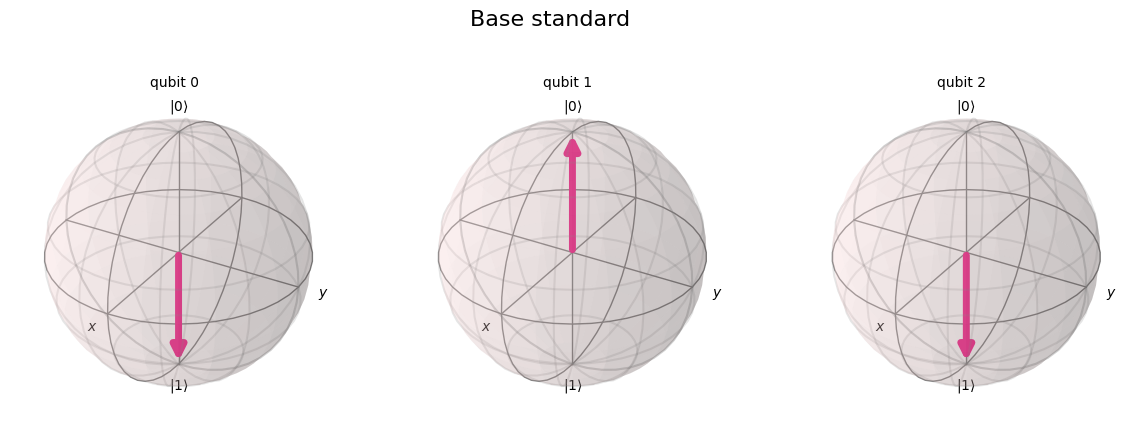

In [12]:
plot_bloch_multivector(statevector, title="Base standard")

In [13]:
base_fourrier = QuantumCircuit(len(bits))
base_fourrier.h(range(len(bits)))
for i in range(len(bits)):
    for _ in range(int(bits)):
        base_fourrier.p(2*np.pi / (2**(i+1)), i)

result = execute(base_fourrier, sim).result()
statevector = result.get_statevector()

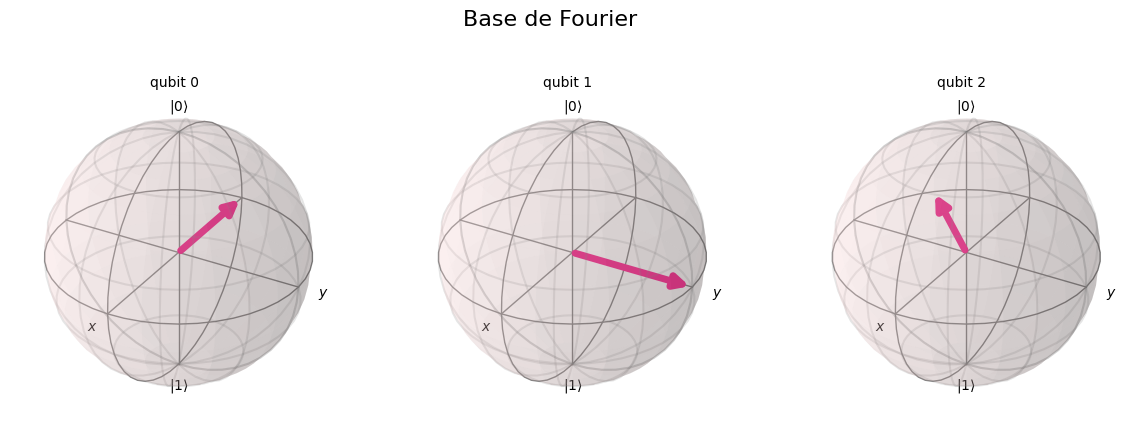

In [14]:
plot_bloch_multivector(statevector, title="Base de Fourier")

Il existe des opérations pour passer d'une base à l'autre que l'on nomme $QFT$ (transformée de Fourrier quantique) et son inverse $QFT^\dagger$.